# 1D synthetic data example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import time

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from scipy.stats.qmc import LatinHypercube
from Aux import *

## Data

In [41]:
def set_ax_lims(ax, ylabel=True):
    ax.set_xlim([-1, 1])
    ax.set_ylim([-3.5, 3.5])
    ax.set_xlabel('$X$', fontsize=13)
    if ylabel:
        ax.set_ylabel('$Y$', fontsize=13)
    for pos in ['right', 'top']: #, 'bottom', 'left']:
        ax.spines[pos].set_visible(False)
    ax.grid(True)

30


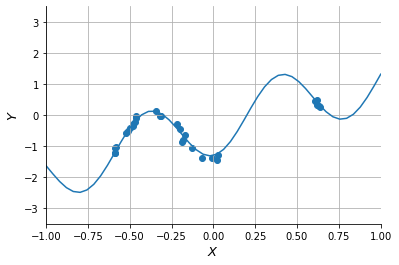

In [45]:
# now it is fixed for consistency
def true_func(x):
    return 1.5 * (x-0.2) + np.sin((x-0.2) * 8)

def generate_data(n1, n2):
    data_x = np.round(np.concatenate(
        [np.random.uniform(-0.6, 0.1, size=n1), np.random.uniform(0.6, 0.65, size=n2)], axis=0), 2)
    data_y = np.round(true_func(data_x) + 0.1 * np.random.normal(size=n1+n2), 2)
    return data_x.reshape((-1,1)), data_y.reshape((-1,1))

#data_x, data_y = generate_data(25, 5)
data_x = np.array([ 0.02, -0.52, -0.46, -0.19, -0.48, -0.59, -0.32, -0.17, -0.31, -0.47, -0.48, -0.46,
 -0.2,  -0.13, -0.18, -0.58, -0.59, -0.07, -0.59, -0.51, -0.34, -0.01,  0.03, -0.22,
 -0.5,   0.63,  0.62,  0.61,  0.64,  0.62]).reshape((-1, 1))
data_y = np.array([-1.45, -0.59, -0.08, -0.88, -0.3,  -1.21, -0.04, -0.63, -0.04, -0.23, -0.35, -0.04,
 -0.45, -1.05, -0.8,  -1.03, -1.06, -1.38, -1.23, -0.5,   0.13, -1.37, -1.27, -0.3,
 -0.43,  0.3,   0.5,   0.44,  0.27,  0.34]).reshape((-1, 1))
print(len(data_x))


fig, ax = plt.subplots()
ax.plot(np.linspace(-1,1), true_func(np.linspace(-1,1)))
ax.scatter(data_x, data_y)
set_ax_lims(ax)
plt.show()

## NN and prior

In [4]:
# Set some properties of the neural network we will train
layers_shape = (20, 20, 20, 20)
act = lambda features: tf.nn.leaky_relu(features, alpha=0.01)
optimizer = Adam(learning_rate=0.001)
nn_kwargs = {'layers_shape': layers_shape, 'act': act, 'noise_scale': 0.1, 'optimizer': optimizer}


In [5]:
tmp_model = create_nn_full(sing_values=None, sing_vectors=None, **nn_kwargs)
print(tmp_model.get_weights())

[array([-0.22207464,  0.25028688, -1.4582206 , ...,  0.00551295,
        0.208588  ,  0.        ], dtype=float32)]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 20)                40        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,321
Trainable params: 1,321
Non-trainable p

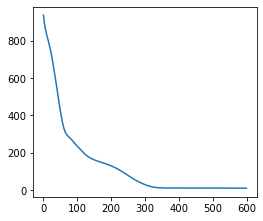

2/2 [==============================] - 0s 16ms/step


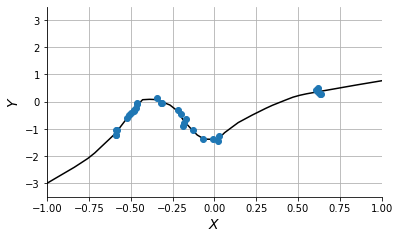

In [6]:
prior_scale = 1.
lmda_reg = 0.1 ** 2 / (len(data_x) * prior_scale ** 2)

model2 = create_nn_per_layer(lmda_reg=lmda_reg, **nn_kwargs)
model2.summary()
history = model2.fit(data_x, data_y, epochs=600, shuffle=True, verbose=0)

fig, ax = plt.subplots(figsize=(4, 3.5))
ax.plot(history.history['loss'])
plt.show()

fig, ax = plt.subplots(figsize=(6, 3.5))
xx = np.linspace(-1, 1)
ax.plot(xx, model2.predict(xx), color='black')
ax.plot(data_x, data_y, linestyle='none', marker='o')
set_ax_lims(ax)
plt.show()

In [7]:
def sample_aleatory(x, y):
    noisy_y = y + np.random.normal(loc=0., scale=0.1, size=y.shape)
    return x, noisy_y

def sample_from_prior(x_prior, mean_coef, L):
    y_prior = mean_coef * x_prior + sample_from_GP(x_prior, k0=1., L=L)
    return y_prior

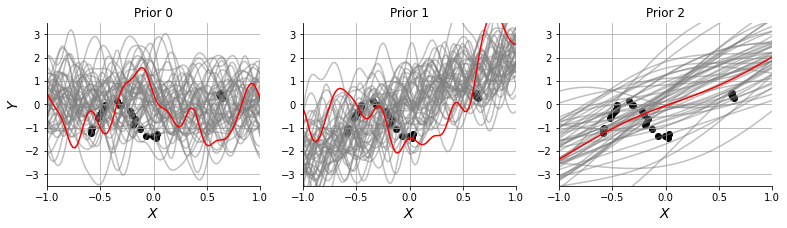

In [8]:
x_values = np.linspace(-1, 1, 100)
fig, ax = plt.subplots(ncols=3, figsize=(13, 3))
for j, (mean_coef, L) in enumerate(zip([0., 2., 2.], [0.1, 0.1, 1.])):
    for i in range(50):
        x_values = np.linspace(-1, 1, 100).reshape((-1, 1))
        y_prior = sample_from_prior(x_values, mean_coef, L)
        if i == 49:
            ax[j].plot(x_values, y_prior, color='red')
        else:
            ax[j].plot(x_values, y_prior, color='gray', alpha=0.5)
    ax[j].scatter(data_x, data_y, color='black')
    set_ax_lims(ax[j], ylabel=(j == 0))
    ax[j].set_title('Prior {}'.format(j))
plt.show()

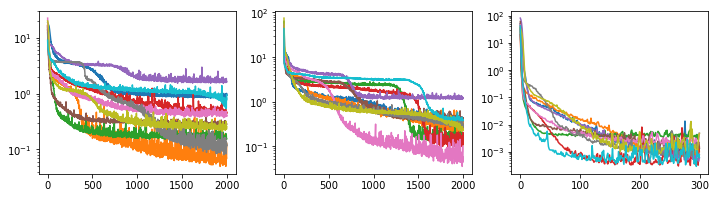

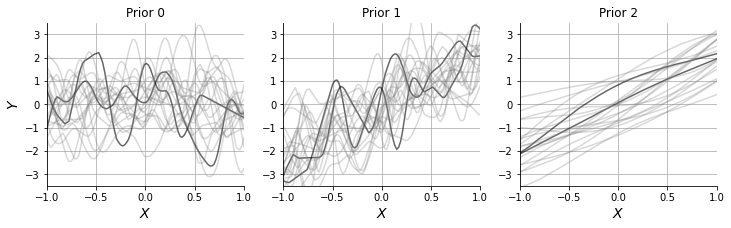

In [9]:
import pickle
with open('priors_080824_N[100]_1d_synthetic.pkl', 'rb') as handle:
    dict_results = pickle.load(handle)
    
tmp_model = create_nn_per_layer(
    layers_shape=layers_shape, act=act, lmda_reg=0., optimizer=optimizer)
x_test = np.linspace(-1, 1, 100).reshape((-1, 1))

fig, ax = plt.subplots(ncols=3, figsize=(12, 3))
for j in range(3):
    _, losses = dict_results['prior_{}'.format(j)]
    for l_ in losses[:10]:
        ax[j].plot(l_)
    ax[j].set_yscale('log')
plt.show()

fig, ax = plt.subplots(ncols=3, figsize=(12, 3))
for j in range(3):
    ws, losses = dict_results['prior_{}'.format(j)]
    for i, w_ in enumerate(ws[:20]):
        tmp_model.set_weights(w_)
        y_pred = tmp_model.predict(x_test, verbose=False)
        if i<2:
            ax[j].plot(x_test, y_pred, color='black', alpha=0.6)
        else:
            ax[j].plot(x_test, y_pred, color='gray', alpha=0.3)
    set_ax_lims(ax[j], ylabel=(j == 0))
    ax[j].set_title('Prior {}'.format(j))
plt.show()

## Vanilla ensembling

In [10]:
N = 40

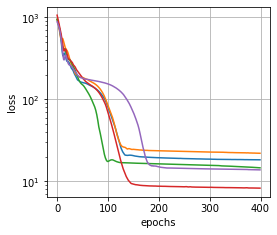

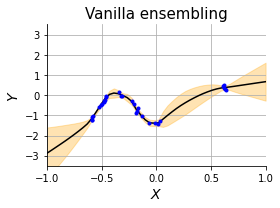

In [19]:

# Fit ensemble
vanilla_ens = VanillaEnsemble(n_ens=N, nn_kwargs=nn_kwargs, sample_from_aleatory=sample_aleatory)
vanilla_ens.fit(x=data_x, y=data_y, epochs=400)

# Predict
xx = np.linspace(-1, 1).reshape((-1,1))
yy_mc = vanilla_ens.predict(xx)[:, :, 0]
yy_mean, yy_std = np.mean(yy_mc, axis=0), np.std(yy_mc, axis=0)
ps = np.percentile(yy_mc, q=[2.5, 97.5], axis=0)

# Plot 
fig, ax = plt.subplots(ncols=1, figsize=(4, 3))
ax.plot(xx, yy_mean, color='black')
ax.fill_between(xx[:,0], yy_mean-2*yy_std, yy_mean+2*yy_std, color='orange', alpha=0.3)
#ax.fill_between(xx[:,0], ps[0, :], ps[1, :], color='green', alpha=0.3)
ax.set_title('Vanilla ensembling', fontsize=15)
ax.plot(data_x, data_y, linestyle='none', marker='.', color='blue')
set_ax_lims(ax)
fig.tight_layout()
plt.show()

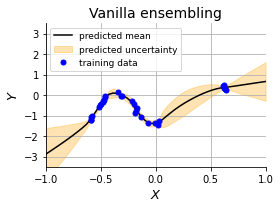

In [42]:
# Predict
xx = np.linspace(-1, 1).reshape((-1,1))
yy_mc = vanilla_ens.predict(xx)[:, :, 0]
yy_mean, yy_std = np.mean(yy_mc, axis=0), np.std(yy_mc, axis=0)
ps = np.percentile(yy_mc, q=[2.5, 97.5], axis=0)
# Plot 
fig, ax = plt.subplots(ncols=1, figsize=(4, 3))
ax.plot(xx, yy_mean, color='black', label='predicted mean')
ax.fill_between(xx[:,0], yy_mean-2*yy_std, yy_mean+2*yy_std, color='orange', alpha=0.3,
               label='predicted uncertainty')
#ax.fill_between(xx[:,0], ps[0, :], ps[1, :], color='green', alpha=0.3)
ax.set_title('Vanilla ensembling', fontsize=14)
ax.plot(data_x, data_y, linestyle='none', marker='o', color='blue', markersize=5, label='training data')
set_ax_lims(ax)
ax.legend(fontsize=9, loc='upper left')
fig.tight_layout()
#fig.savefig('example1D_vanilla.png', bbox_inches='tight')
plt.show()

## Anchored ensembling prior 1

In [12]:
def plot_with_prior(anc_ens):
    fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
    xx = np.linspace(-1, 1).reshape((-1,1))
    for i, which_dist in enumerate(['prior', 'posterior']):
        yy_mc = anc_ens.predict(xx, which_dist=which_dist)[:, :, 0]
        yy_mean, yy_std = np.mean(yy_mc, axis=0), np.std(yy_mc, axis=0)
        ps = np.percentile(yy_mc, q=[2.5, 97.5], axis=0)

        ax[i].plot(xx, yy_mean, color='black')
        for yy_ in yy_mc[:2]:
            ax[i].plot(xx, yy_, color='gray')
        ax[i].fill_between(xx[:,0], yy_mean-2*yy_std, yy_mean+2*yy_std, color='orange', alpha=0.3)
        #ax.fill_between(xx[:,0], ps[0, :], ps[1, :], color='green', alpha=0.3)

        #y_val_pred = anchored_ens.predict(data_val_x, which_dist=which_dist)
        #lppd_val = compute_lppd_from_ensemble_preds(data_val_y, y_val_pred, noise_scale=0.2)
        ax[i].set_title(which_dist, fontsize=15)
        ax[i].plot(data_x, data_y, linestyle='none', marker='.', color='blue')
        set_ax_lims(ax[i])
    fig.tight_layout()
    plt.show()

Fitting to data


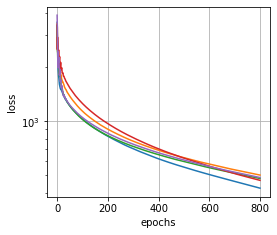

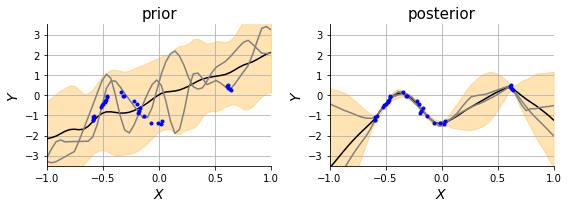

In [13]:
ws, _ = dict_results['prior_1']

anchored_ens_1 = AnchoredEnsemble(N, nn_kwargs, sample_from_aleatory=sample_aleatory,prior_weights=ws[:N])
anchored_ens_1.fit(x=data_x, y=data_y, epochs=800)
plot_with_prior(anchored_ens_1)

Fitting to data


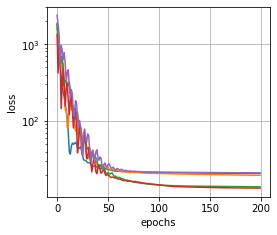

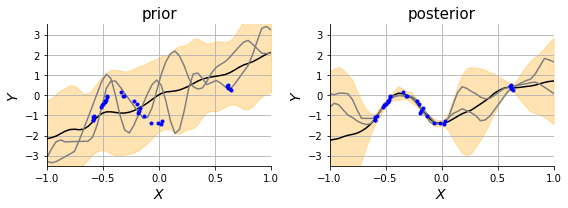

In [14]:
ws, _ = dict_results['prior_1']
ws_new = []
for n, ws_ in enumerate(ws[:N]):
    concat_w = np.concatenate([w_.reshape((-1,)) for w_ in ws_], axis=0)
    ws_new.append([concat_w, ])
    
anchored_ens_1_bis = AnchoredEnsemble(
    N, nn_kwargs, sample_from_aleatory=sample_aleatory, prior_weights=ws_new, which_reg='degenerate_gaussian')
anchored_ens_1_bis.fit(x=data_x, y=data_y, epochs=200)
plot_with_prior(anchored_ens_1_bis)

## Anchored ensembling prior 2

Fitting to data


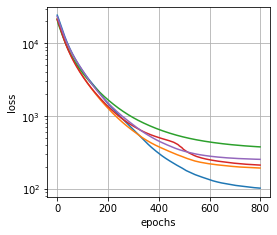

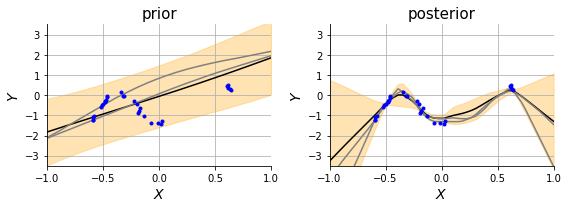

In [15]:
ws, _ = dict_results['prior_2']

anchored_ens_2 = AnchoredEnsemble(N, nn_kwargs, sample_from_aleatory=sample_aleatory,prior_weights=ws[:N])
anchored_ens_2.fit(x=data_x, y=data_y, epochs=800)
plot_with_prior(anchored_ens_2)

Fitting to data


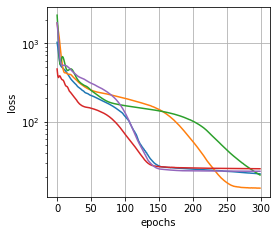

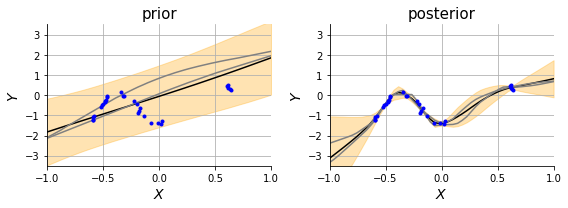

In [16]:
ws, _ = dict_results['prior_2']
ws_new = []
for n, ws_ in enumerate(ws[:N]):
    concat_w = np.concatenate([w_.reshape((-1,)) for w_ in ws_], axis=0)
    ws_new.append([concat_w, ])
    
anchored_ens_2_bis = AnchoredEnsemble(
    N, nn_kwargs, sample_from_aleatory=sample_aleatory, prior_weights=ws_new, which_reg='degenerate_gaussian')
anchored_ens_2_bis.fit(x=data_x, y=data_y, epochs=300)
plot_with_prior(anchored_ens_2_bis)

## Plots for paper

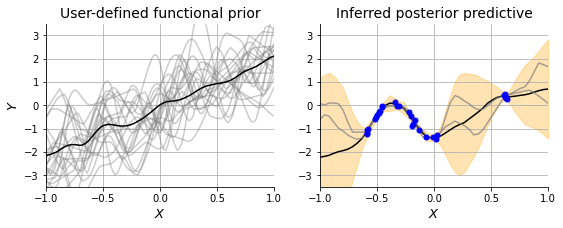

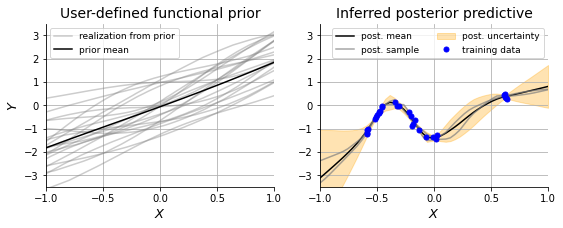

In [43]:
tmp_model = create_nn_per_layer(
    layers_shape=layers_shape, act=act, lmda_reg=0., optimizer=optimizer)
x_test = np.linspace(-1, 1, 100).reshape((-1, 1))

for prior_nb, anc_ens in zip(['prior_1', 'prior_2'], [anchored_ens_1_bis, anchored_ens_2_bis]):
    ws, losses = dict_results[prior_nb]

    fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
    # Prior
    yy_mc = []
    for i, w_ in enumerate(ws[:N]):
        tmp_model.set_weights(w_)
        y_pred = tmp_model.predict(x_test, verbose=False)
        if i < 20:
            ax[0].plot(x_test, y_pred, color='gray', alpha=0.4, label='realization from prior' if i==0 else None)
        yy_mc.append(y_pred)
    yy_mean = np.mean(np.array(yy_mc), axis=0)
    ax[0].plot(x_test, yy_mean, color='black', label='prior mean')
    # Posterior
    xx = np.linspace(-1, 1).reshape((-1,1))
    yy_mc = anc_ens.predict(xx, which_dist='posterior')[:, :, 0]
    yy_mean, yy_std = np.mean(yy_mc, axis=0), np.std(yy_mc, axis=0)
    ps = np.percentile(yy_mc, q=[2.5, 97.5], axis=0)
    ax[1].plot(xx, yy_mean, color='black', label='post. mean')
    for i, yy_ in enumerate(yy_mc[:2]):
        ax[1].plot(xx, yy_, color='gray', alpha=0.7, label='post. sample' if i==0 else None)
    ax[1].fill_between(xx[:,0], yy_mean-2*yy_std, yy_mean+2*yy_std, color='orange', alpha=0.3, 
                       label='post. uncertainty')
    #ax[1].fill_between(xx[:,0], ps[0, :], ps[1, :], color='orange', alpha=0.3)
    ax[1].plot(data_x, data_y, linestyle='none', marker='o', color='blue', markersize=5, label='training data')
    for j in range(2):
        set_ax_lims(ax[j], ylabel=(j == 0))
    ax[0].set_title('User-defined functional prior', fontsize=14)
    ax[1].set_title('Inferred posterior predictive', fontsize=14)
    if prior_nb=='prior_2':
        ax[0].legend(fontsize=9)
        ax[1].legend(ncol=2, loc='upper right', fontsize=9)
    #fig.savefig('example1D_correlation_{}.png'.format(prior_nb), bbox_inches='tight')
    plt.show()



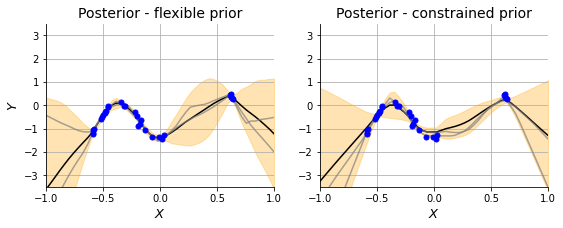

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
for j, anc_ens in enumerate([anchored_ens_1, anchored_ens_2]):
    ws, losses = dict_results[prior_nb]
    # Posterior
    xx = np.linspace(-1, 1).reshape((-1,1))
    yy_mc = anc_ens.predict(xx, which_dist='posterior')[:, :, 0]
    yy_mean, yy_std = np.mean(yy_mc, axis=0), np.std(yy_mc, axis=0)
    ps = np.percentile(yy_mc, q=[2.5, 97.5], axis=0)
    ax[j].plot(xx, yy_mean, color='black')
    for yy_ in yy_mc[:2]:
        ax[j].plot(xx, yy_, color='gray', alpha=0.7)
    ax[j].fill_between(xx[:,0], yy_mean-2*yy_std, yy_mean+2*yy_std, color='orange', alpha=0.3)
    #ax[j].fill_between(xx[:,0], ps[0, :], ps[1, :], color='orange', alpha=0.3)
    ax[j].plot(data_x, data_y, linestyle='none', marker='o', color='blue', markersize=5)
    set_ax_lims(ax[j], ylabel=(j == 0))
ax[0].set_title('Posterior - flexible prior', fontsize=14)
ax[1].set_title('Posterior - constrained prior', fontsize=14)
#fig.savefig('example1D_no_correlation.png', bbox_inches='tight')
plt.show()